In [1]:
# from a notebook cell you can run:
!pip install prophet scikit-learn pandas matplotlib jupyterlab --quiet


In [21]:
import pandas as pd

# Load aggregate data
df_agg = pd.read_csv("retail_sales_monthly_aggregate (1).csv")
print("Aggregate Data:")
display(df_agg.head())

# Load store-level data
df_store = pd.read_csv("retail_sales_monthly_store_level (2).csv")
print("Store-Level Data:")
display(df_store.head())


Aggregate Data:


,ds,y
0,2022-01-01,205826.00
1,2022-02-01,193968.30
2,2022-03-01,200615.55
3,2022-04-01,160043.85
4,2022-05-01,177941.15


Store-Level Data:


,Store,Month,Sales
0,Store_A,2022-01-01,43654.00
1,Store_A,2022-02-01,35937.86
2,Store_A,2022-03-01,21145.71
3,Store_A,2022-04-01,25818.57
4,Store_A,2022-05-01,50373.43


          ds          y
0 2022-01-01  205826.00
1 2022-02-01  193968.30
2 2022-03-01  200615.55
3 2022-04-01  160043.85
4 2022-05-01  177941.15


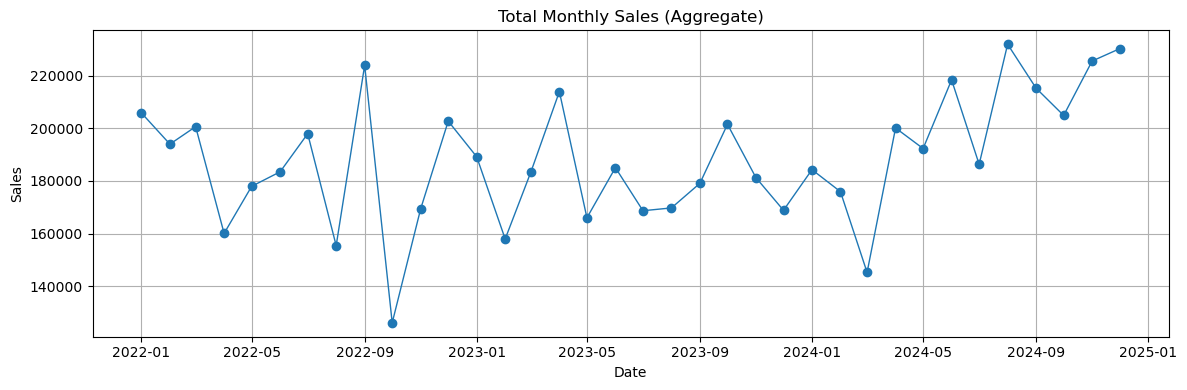

Train range: 2022-01-01 00:00:00 to 2023-12-01 00:00:00
Test range: 2024-01-01 00:00:00 to 2024-12-01 00:00:00


15:32:26 - cmdstanpy - INFO - Chain [1] start processing
15:33:00 - cmdstanpy - INFO - Chain [1] done processing


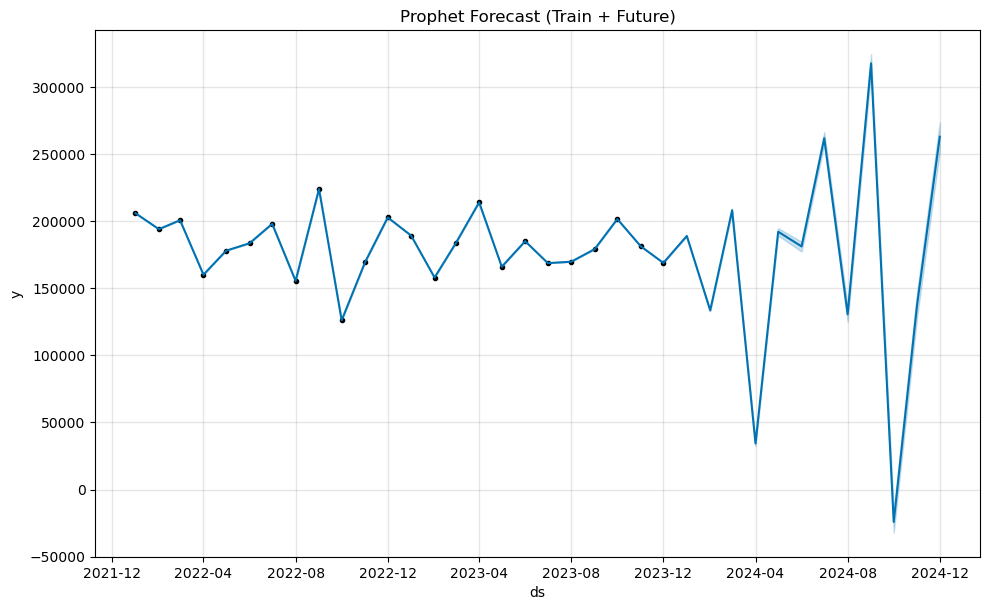

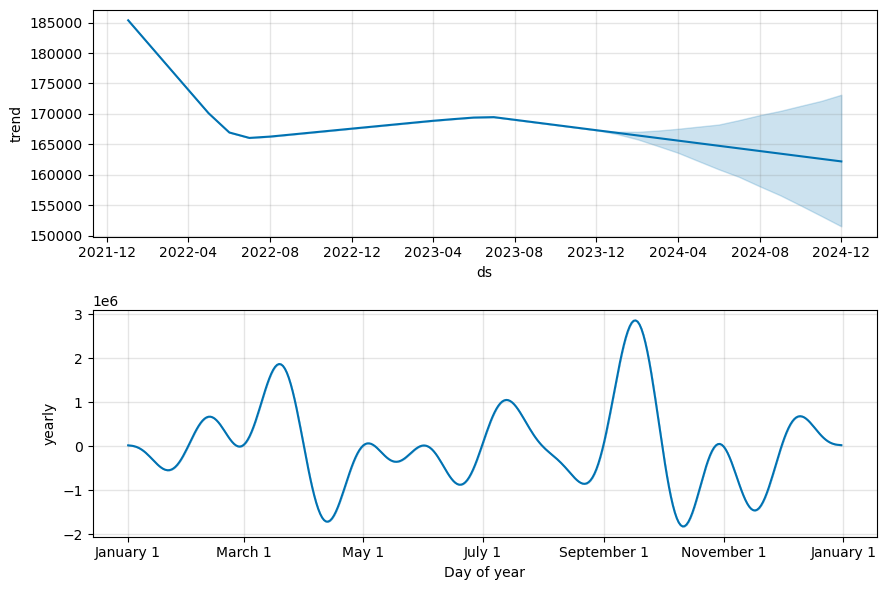

Prophet MAE: 78464.02
Prophet RMSE: 100947.84
Saved: prophet_forecast_next_12m.csv


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Correct file paths (with spaces in names)
agg_path = "retail_sales_monthly_aggregate (1).csv"   # Aggregated sales
store_path = "retail_sales_monthly_store_level (1).csv"  # Store-level sales (not used in this example)

# Load the aggregated CSV
df = pd.read_csv(agg_path, parse_dates=["ds"])
df = df.sort_values("ds")

# Quick preview
print(df.head())

# Plot total monthly sales
plt.figure(figsize=(12,4))
plt.plot(df['ds'], df['y'], marker='o', linewidth=1)
plt.title("Total Monthly Sales (Aggregate)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecasting setup
horizon = 12  # forecast next 12 months
train_df = df.iloc[:-horizon].copy()
test_df  = df.iloc[-horizon:].copy()

print("Train range:", train_df['ds'].min(), "to", train_df['ds'].max())
print("Test range:", test_df['ds'].min(), "to", test_df['ds'].max())

# Train Prophet model
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(train_df)

# Create future dataframe
future = m.make_future_dataframe(periods=horizon, freq='MS')  # Month start
forecast = m.predict(future)

# Plot forecast
m.plot(forecast)
plt.title("Prophet Forecast (Train + Future)")
plt.show()

m.plot_components(forecast)
plt.show()

# Merge forecast with actual test data
fc_horizon = forecast[['ds','yhat']].set_index('ds').join(test_df.set_index('ds')['y'])
fc_horizon = fc_horizon.dropna().reset_index()

# Calculate metrics
y_true = fc_horizon['y'].values
y_pred = fc_horizon['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

# Save forecast to CSV
out = forecast[['ds','yhat','yhat_lower','yhat_upper']].copy()
out.to_csv(f"prophet_forecast_next_{horizon}m.csv", index=False)
print(f"Saved: prophet_forecast_next_{horizon}m.csv")
